# Laboratorium 4

### Konfiguracja

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

FIG_EPS = 0.05

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < FIG_EPS:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [3]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    def get_added_rects(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


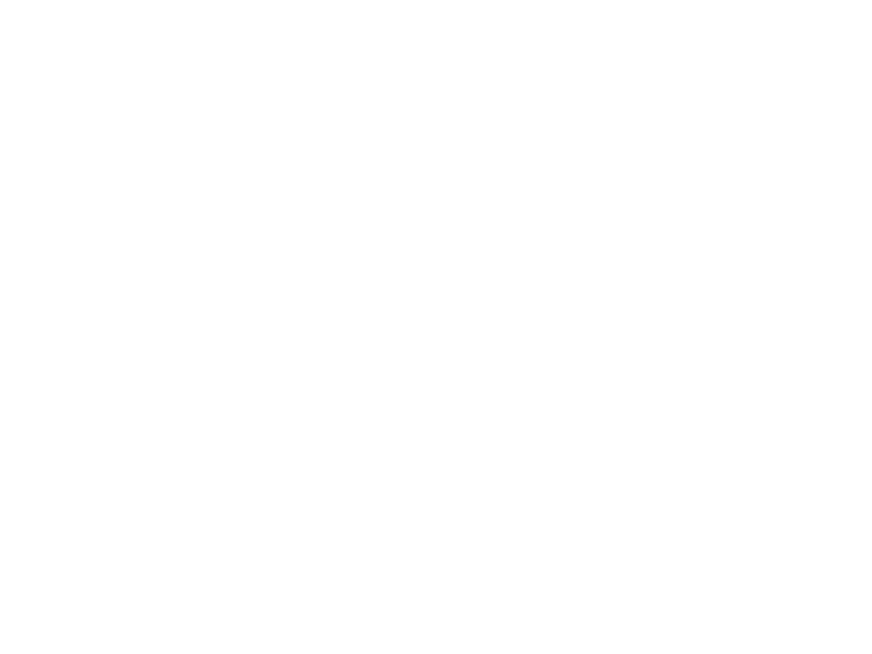

In [4]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


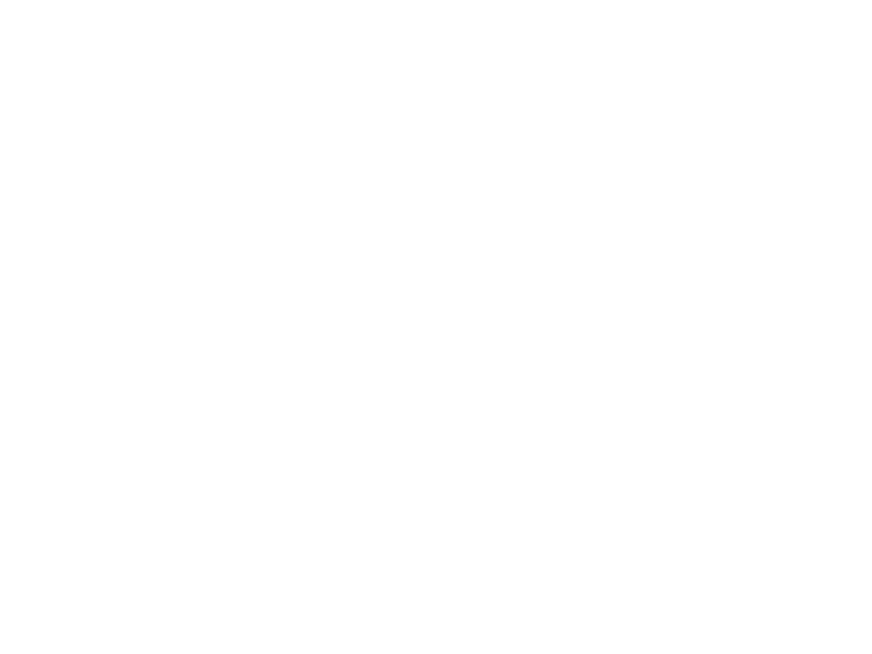

In [5]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


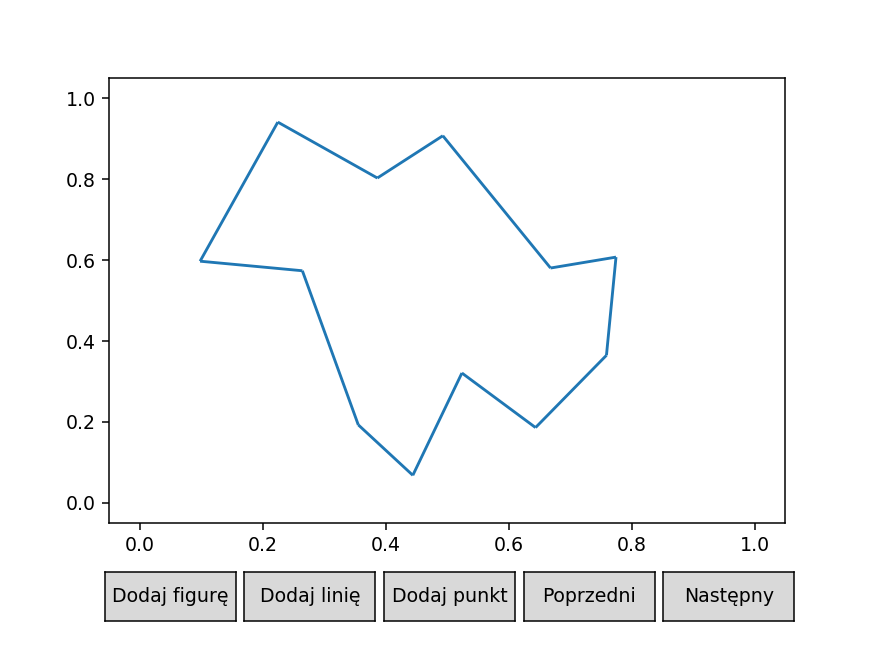

In [90]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

1
[(0.44396506278745607, 0.06812195009460642), (0.5238037724648753, 0.32087930303578294), (0.6435618369810044, 0.1860753814671554), (0.7588844176261658, 0.36469057754558687), (0.7744086111745528, 0.6073376363691162), (0.667956998271327, 0.5803768520553908), (0.49275538536810115, 0.9072763618593125), (0.38630377246487535, 0.8028033226436262), (0.22440861117455274, 0.9409773422514693), (0.0979973208519721, 0.5972273422514692), (0.26432796601326247, 0.5736366559769593), (0.3552553853681012, 0.19281557754558676)]


<IPython.core.display.Javascript object>


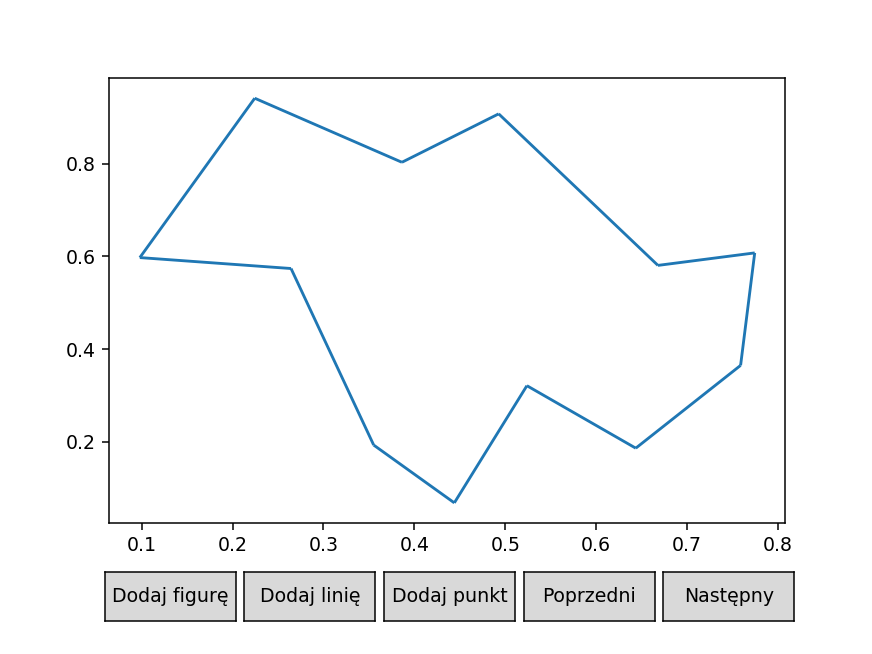

In [91]:
plot2 = Plot([plot1.get_added_elements()])
polygonsCol = plot1.get_added_rects()
polygons = []
for polygon in polygonsCol:
    if len(polygon.lines)>2:
        polygons.append(Polygon(polygon.lines))
print(len(polygons))
for p in polygons:
    print(p)
plot2.draw()

### Rozwiązanie

In [46]:
class Polygon:
    def __init__(self, lines):
        if len(lines)<3:
            raise Exception(" polygon must have at least 3 edges! given ", len(lines))
        self.lines = lines
        self.points = []
        self.create_points(lines)
    
    def create_points(self, lines):
        for line in lines:
            self.points.append(line[0])
    
    def get_utmost_point_ind(self, cmp):
        y_ind = 0
        y = self.points[0][1]
        for i in range(1, len(self.points)):
            if cmp(self.points[i][1], y):
                y_ind = i
                y = self.points[i][1]
        return y_ind

    def __repr__(self):
        return str(self.points)


In [67]:
%matplotlib notebook
def traverse(pts, maxInd, minInd, step):
    prev = maxInd
    curr = (prev+step)%len(pts)
    while curr != minInd:
        if pts[curr][1] > pts[prev][1]:
            return False
        prev = curr
        curr = (prev+step)%len(pts)
    return True

def is_y_monotonous(poly: Polygon):
    V = len(poly.points)
    max_y_at = poly.get_utmost_point_ind(lambda a,b: a>b) 
    min_y_at = poly.get_utmost_point_ind(lambda a,b: a<b)
    return traverse(poly.points, max_y_at, min_y_at, -1) and \
            traverse(poly.points, max_y_at, min_y_at, +1)

is_y_monotonous(polygons[0])
    

True

In [83]:
def orient(a, b, c, eps=1e-12):  # zwraca znak wyznacznika z dokładnością do eps
    matrix = [[a[0], a[1], 1], [b[0], b[1], 1], [c[0], c[1], 1]]
    det = 0
    for j in range(0, 3):
        det += matrix[0][j]*matrix[1][(j+1)%3]*matrix[2][(j+2)%3]
    for j in range(0, 3):
        det -= matrix[2][j]*matrix[1][(j+1)%3]*matrix[0][(j+2)%3]
    if det>eps:
        return 1
    elif det<-eps:
        return -1
    return 0

<IPython.core.display.Javascript object>


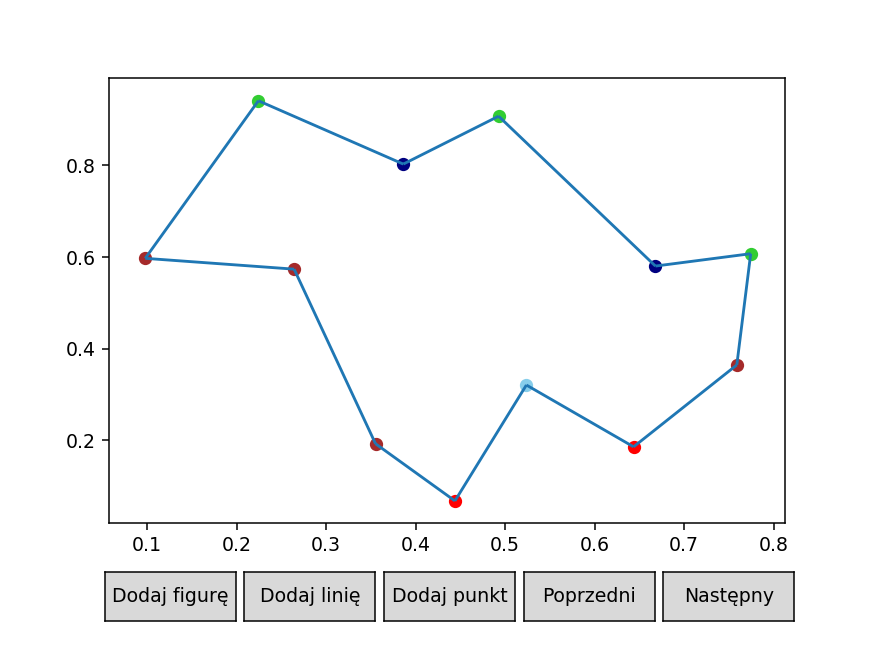

In [102]:
def find_vert(poly: Polygon):
    pts = {"start": [], "end": [], "merge": [], "div": [], "ok": []}
    V = len(poly.points)
    for ind, pt in enumerate(poly.points):
        prev = poly.points[ind-1]
        nex = poly.points[(ind+1)%V]
        if prev[1] > pt[1] and nex[1] > pt[1]:
            if orient(prev, pt, nex) > 0:  # inner ange<pi
                pts["end"].append(pt)
            else:
                pts["merge"].append(pt)
        elif prev[1] < pt[1] and nex[1] < pt[1]:
            if orient(prev, pt, nex) > 0:  # inner ange<pi
                pts["start"].append(pt)
            else:
                pts["div"].append(pt)
        else:
            pts["ok"].append(pt)
    return(pts)
        
pts = find_vert(polygons[0])
scene = Scene([PointsCollection(pts["ok"], color='brown'),
               PointsCollection(pts["end"], color='red'),
               PointsCollection(pts["start"], color='limegreen'),
               PointsCollection(pts["div"], color='skyblue'),
               PointsCollection(pts["merge"], color='navy'),
              ],
             [LinesCollection(polygons[0].lines)])
plot3 = Plot([scene])
plot3.draw()


In [103]:
def triangulate(poly: Polygon):
    pass

In [ ]:
class Point:
    def __init__(self, coord):
        self.coord = coord
        self.x = coord[0]
        self.y = coord[1]
        self.neighs = []
        
    def add_neigh(other: 'Point'):
        self.neighs.append(other)
        
    def get_lower_neigh(): # returns lower neigh or None if doesnt exist
        for neigh in self.neighs:
            if neigh.y <= self.y:
                return neigh
        return None
    def __repr__(self):
        return self.x, self.y
    def __hash__(self):
        return hash( (self.x, self.y))
    def __eq__(self, other):
        return self.coord == other.coord
        

        
